## Setup, Loading Data and CDFs

In [3]:
DATA_NAME = 'pastis-full' 
TRANSFORM = 'fourier'
CHANNEL = 'gray'

In [4]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_fourier_full_pastis.ipynb


In [5]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = True
CWD

'/Volumes/SSD/hbmv/hierarchical-bayesian-model-validation/results/case-studies/pastis/full/fourier/gray'

In [6]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [7]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [ ]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 31800,
 3: 22260,
 4: 44520,
 5: 41340,
 6: 50880,
 7: 54060,
 8: 66780,
 9: 63600,
 10: 85860,
 11: 104940,
 12: 111300,
 13: 136740,
 14: 162180,
 15: 187620,
 16: 203520,
 17: 257580,
 18: 289380,
 19: 337080,
 20: 381600,
 21: 470640,
 22: 540600,
 23: 610560,
 24: 712320,
 25: 855420,
 26: 973080,
 27: 1154340,
 28: 1316520,
 29: 1376940,
 30: 960360,
 31: 674160,
 32: 419760,
 33: 162180}

Running 12760 CDFs


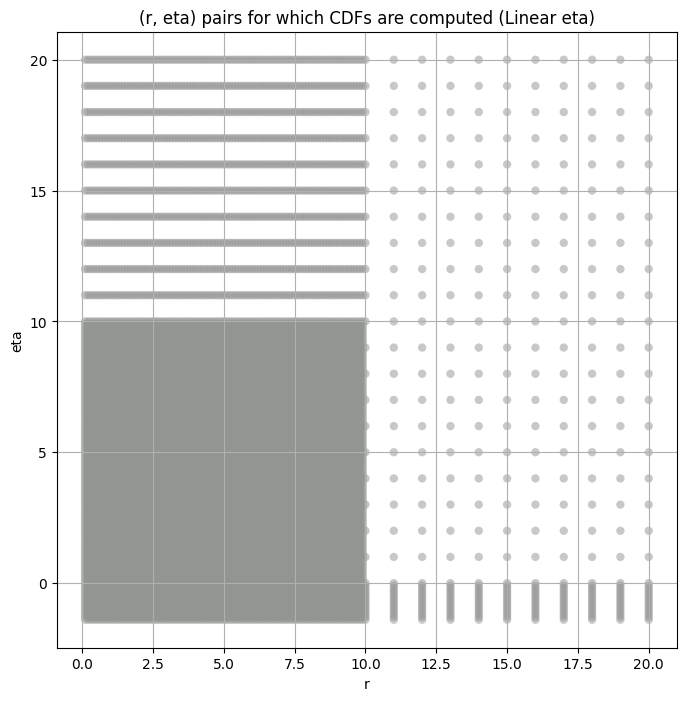

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [9]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index().drop("index", axis = 1)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [10]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [11]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [00:17<00:00, 5779.71it/s]


Band 5


100%|██████████| 100000/100000 [00:24<00:00, 4142.16it/s]


Band 8


100%|██████████| 100000/100000 [00:27<00:00, 3587.95it/s]


Band 11


100%|██████████| 100000/100000 [00:20<00:00, 4852.68it/s]


Band 14


100%|██████████| 100000/100000 [00:20<00:00, 4872.98it/s]


Band 17


100%|██████████| 100000/100000 [00:20<00:00, 4841.70it/s]


Band 20


100%|██████████| 100000/100000 [00:20<00:00, 4875.34it/s]


Band 23


100%|██████████| 100000/100000 [00:20<00:00, 4879.12it/s]


Band 26


100%|██████████| 100000/100000 [00:20<00:00, 4878.38it/s]


Band 29


100%|██████████| 100000/100000 [00:20<00:00, 4873.77it/s]


Band 32


100%|██████████| 100000/100000 [00:20<00:00, 4870.96it/s]


obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     10.134422   9.643435  10.646572   1.621352    1.183683    2.159779   
5      5.424390   5.164831   5.694692   1.556881    1.034867    2.247035   
8      2.974848   2.833664   3.120628   1.541575    1.065818    2.175573   
11     1.695055   1.610400   1.784300   1.922300    1.152667    3.322009   
14     0.926228   0.881725   0.973125   1.705795    1.083743    3.005845   
17     0.518186   0.492855   0.544779   1.771588    1.108579    3.490519   
20     0.260627   0.247789   0.274535   1.956200    1.143715    5.900508   
23     0.122159   0.116055   0.128693   2.041856    1.252694    3.881752   
26     0.049178   0.046151   0.053056   5.035482    1.824682   19.982931   
29     0.015548   0.014031   0.017973  20.922686    4.499840   88.633370   
32     0.001337   0.001274   0.001402   1.474466    0.992683    2.485555   

      total_samples  
band                 
2           31800.0  
5           41340.0  
8           66780.0  
11         104940.0  
14         162180.0  
17         257580.0  
20         381600.0  
23         610560.0  
26         973080.0  
29        1376940.0  
32         419760.0

## Initial Grid Search and Hypothesis Test Plots

In [12]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [13]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                             
2     10.134422      10.134422        9.782848        9.546412   
5      5.424390       5.424390        5.263988        5.168985   
8      2.974848       2.974848        2.915290        2.875796   
11     1.695055       1.695055        1.663257        1.645027   
14     0.926228       0.926228        0.911027        0.901737   
17     0.518186       0.518186        0.509296        0.503911   
20     0.260627       0.260627        0.256206        0.253544   
23     0.122159       0.122159        0.119913        0.118575   
26     0.049178       0.049178        0.047630        0.046923   
29     0.015548       0.015548        0.014465        0.014051   
32     0.001337       0.001337        0.001318        0.001305   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2           9.353152         9.182628         8.889160         8.640179   
5           5.086771         5.014502         4.888740         4.776872   
8           2.842202         2.812102         2.758150         2.710953   
11          1.629946         1.616589         1.593062         1.572441   
14          0.893657         0.886373         0.873591         0.862387   
17          0.499483         0.495506         0.488453         0.482207   
20          0.251270         0.249237         0.245621         0.242386   
23          0.117447         0.116448         0.114696         0.113161   
26          0.046376         0.045902         0.045096         0.044404   
29          0.013759         0.013531         0.013175         0.012896   
32          0.001293         0.001284         0.001266         0.001250   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2            8.418350         8.217493         8.032310         7.546413  
5            4.675648         4.582586         4.496524         4.266775  
8            2.668601         2.629780         2.593668         2.497113  
11           1.553386         1.535631         1.518962         1.474134  
14           0.852188         0.842727         0.833824         0.809826  
17           0.476513         0.471247         0.466325         0.453006  
20           0.239438         0.236714         0.234168         0.227321  
23           0.111766         0.110477         0.109277         0.106054  
26           0.043791         0.043232         0.042716         0.041357  
29           0.012662         0.012459         0.012277         0.011813  
32           0.001236         0.001222         0.001210         0.001176

####
Band  2


100%|██████████| 12760/12760 [00:08<00:00, 1461.55it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.0034661060093252316 10.134422


100%|██████████| 12760/12760 [00:08<00:00, 1487.71it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.0034874760983374387 9.782848


100%|██████████| 12760/12760 [00:08<00:00, 1485.58it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.0034852631116448346 9.546412
Number of samples: 31800, Without approximation : 31800.0


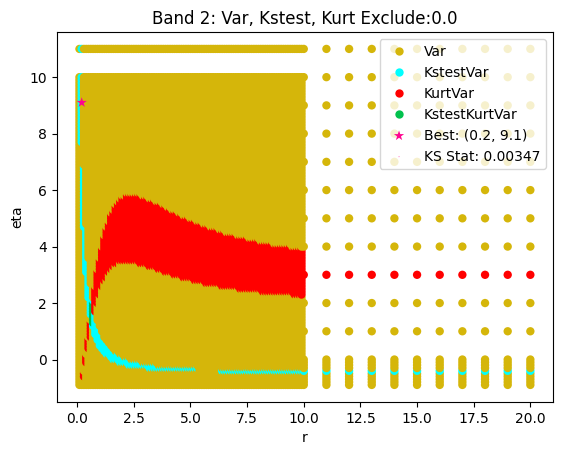

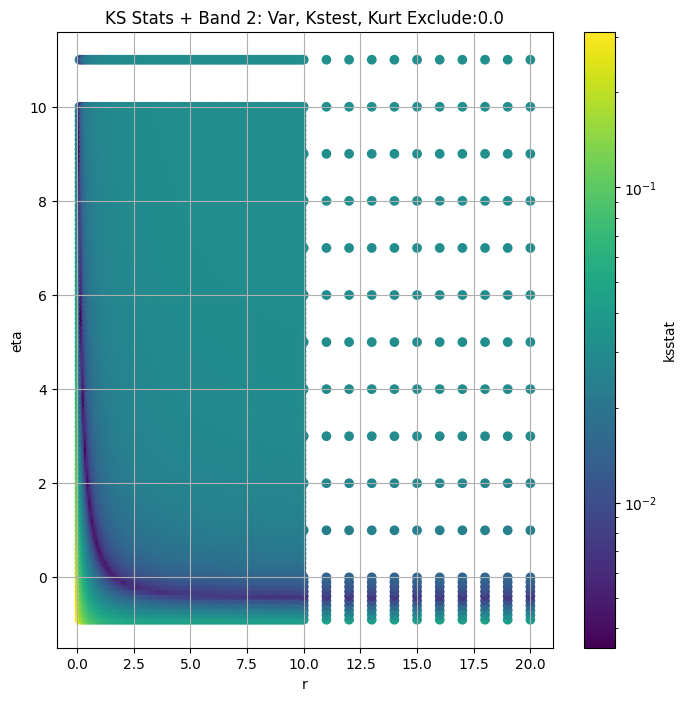

####
Band  5


100%|██████████| 12760/12760 [00:11<00:00, 1138.32it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.002604391362178715 5.42439


100%|██████████| 12760/12760 [00:11<00:00, 1124.32it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.002571387231145361 5.2639885


100%|██████████| 12760/12760 [00:11<00:00, 1146.35it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.0031517104615489955 5.168985


100%|██████████| 12760/12760 [00:11<00:00, 1144.36it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.0038162638219164657 5.086771
Number of samples: 41340, Without approximation : 41340.0


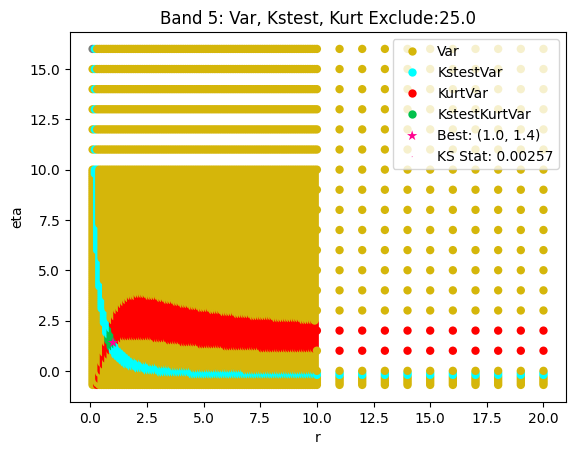

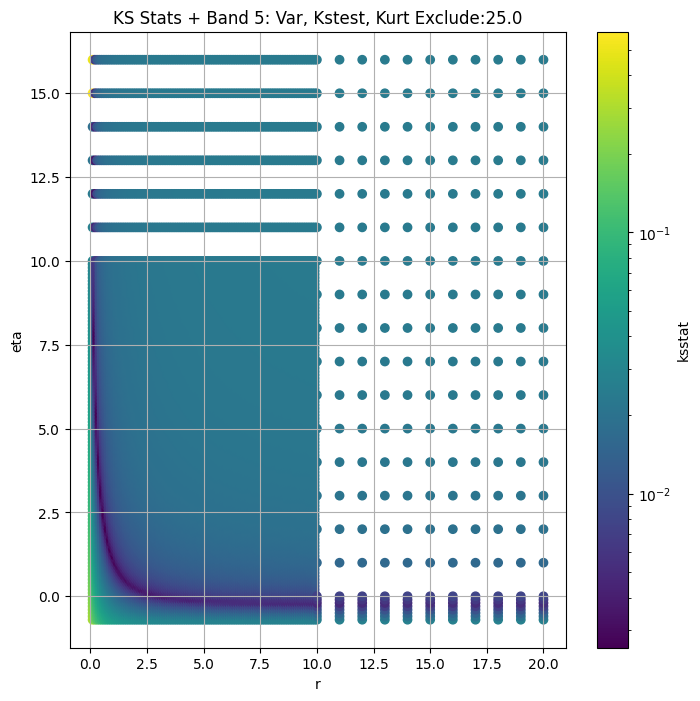

####
Band  8


100%|██████████| 12760/12760 [00:18<00:00, 702.68it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.003311206006953671 2.9748478


100%|██████████| 12760/12760 [00:17<00:00, 711.82it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.003260632456174417 2.9152899


100%|██████████| 12760/12760 [00:17<00:00, 713.01it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.0031978040293493826 2.8757958


100%|██████████| 12760/12760 [00:17<00:00, 714.48it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.0031984994023699365 2.8422022


100%|██████████| 12760/12760 [00:18<00:00, 688.45it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.003316408942133031 2.812102
Number of samples: 66780, Without approximation : 66780.0


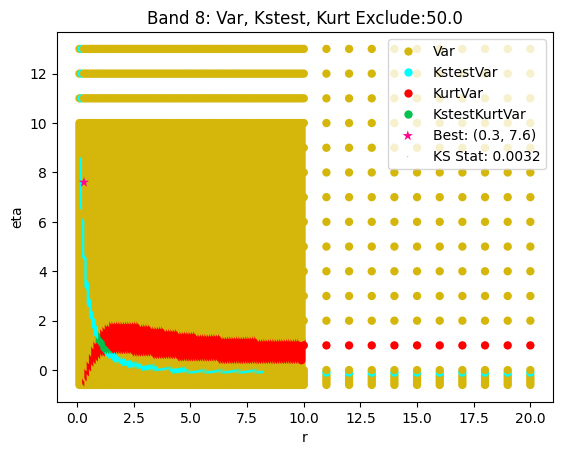

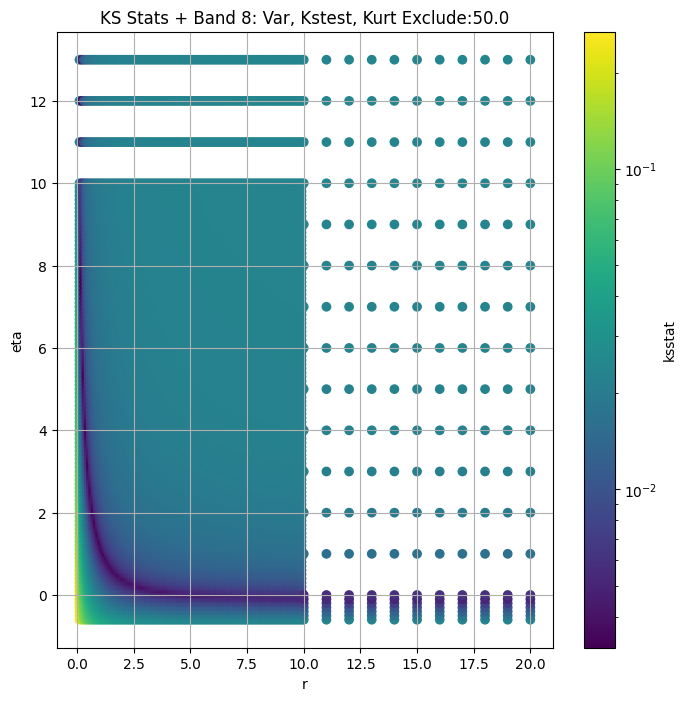

####
Band  11


100%|██████████| 12760/12760 [00:27<00:00, 460.09it/s]


Finding Minimum after computing 12760 CDFs
11 0 0.0019501888073865103 1.6950549


100%|██████████| 12760/12760 [00:27<00:00, 465.11it/s]


Finding Minimum after computing 12760 CDFs
11 25 0.0016804652792987707 1.6632574


100%|██████████| 12760/12760 [00:27<00:00, 465.65it/s]


Finding Minimum after computing 12760 CDFs
11 50 0.0016696639721338613 1.6450269


100%|██████████| 12760/12760 [00:27<00:00, 464.57it/s]


Finding Minimum after computing 12760 CDFs
11 75 0.0016926045126798572 1.6299461


100%|██████████| 12760/12760 [00:27<00:00, 464.41it/s]


Finding Minimum after computing 12760 CDFs
11 100 0.0018848851819784108 1.6165886
Number of samples: 100000, Without approximation : 104940.0


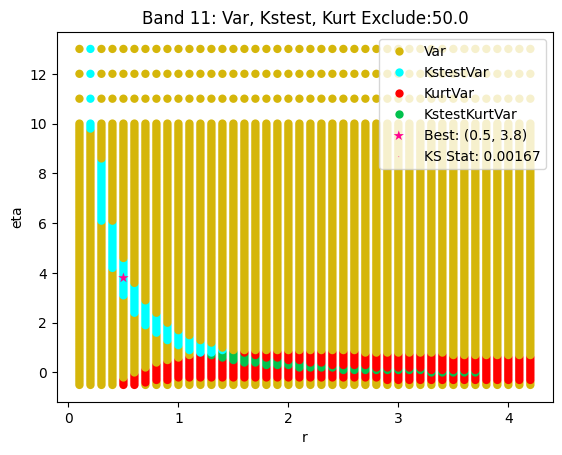

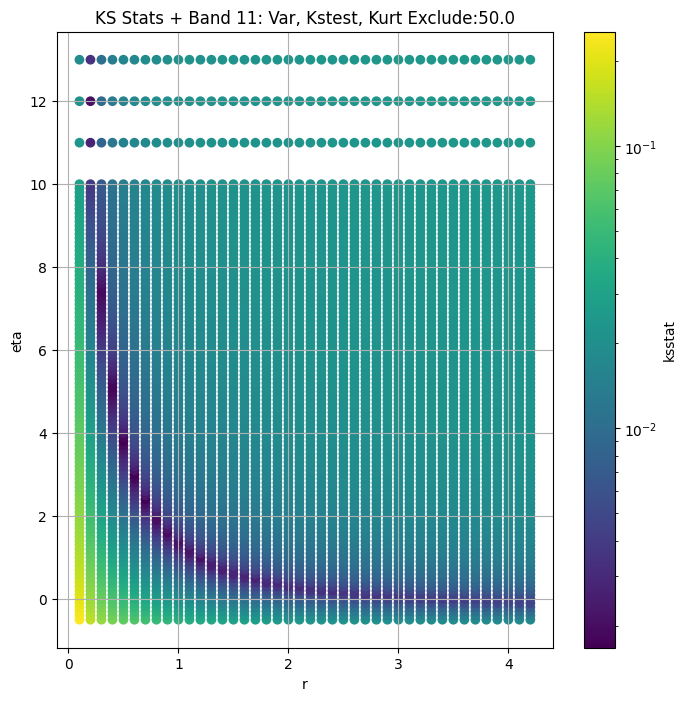

####
Band  14


100%|██████████| 12760/12760 [00:27<00:00, 464.05it/s]


Finding Minimum after computing 12760 CDFs
14 0 0.00260495959174184 0.92622846


100%|██████████| 12760/12760 [00:27<00:00, 465.05it/s]


Finding Minimum after computing 12760 CDFs
14 25 0.002638222997243589 0.91102684


100%|██████████| 12760/12760 [00:44<00:00, 284.34it/s]


Finding Minimum after computing 12760 CDFs
14 50 0.0025767875957370956 0.901737


100%|██████████| 12760/12760 [00:28<00:00, 450.36it/s]


Finding Minimum after computing 12760 CDFs
14 75 0.0026273647815112655 0.89365673
Number of samples: 100000, Without approximation : 162180.0


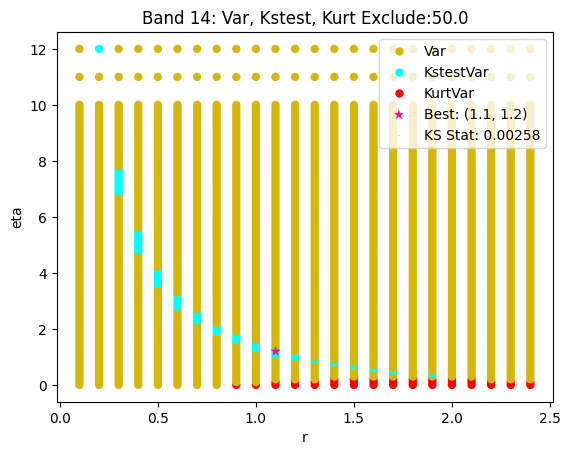

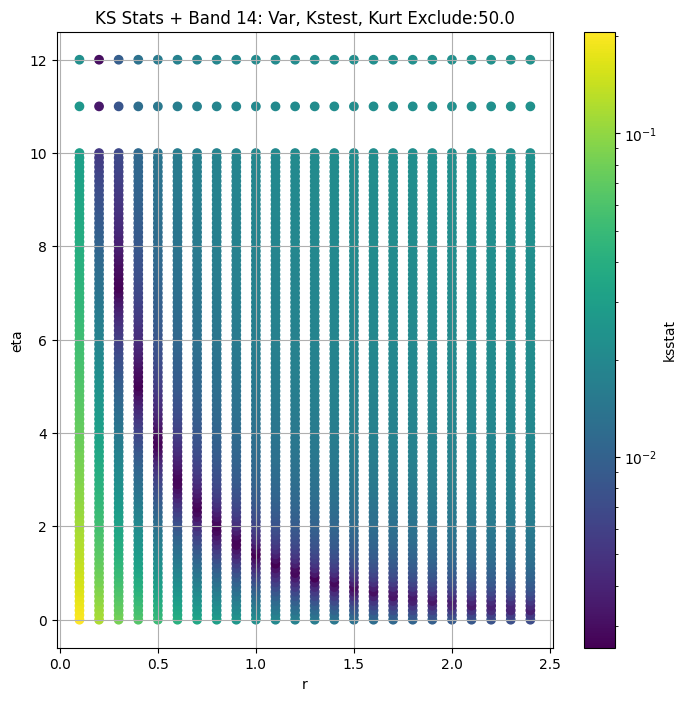

####
Band  17


100%|██████████| 12760/12760 [00:27<00:00, 462.29it/s]


Finding Minimum after computing 12760 CDFs
17 0 0.0008342284807046768 0.51818645


100%|██████████| 12760/12760 [00:27<00:00, 462.73it/s]


Finding Minimum after computing 12760 CDFs
17 25 0.0008280792199057974 0.50929636


100%|██████████| 12760/12760 [00:27<00:00, 463.49it/s]


Finding Minimum after computing 12760 CDFs
17 50 0.0011139905873585043 0.5039107


100%|██████████| 12760/12760 [00:27<00:00, 462.02it/s]


Finding Minimum after computing 12760 CDFs
17 75 0.0015094724952900984 0.4994832
Number of samples: 100000, Without approximation : 257580.0


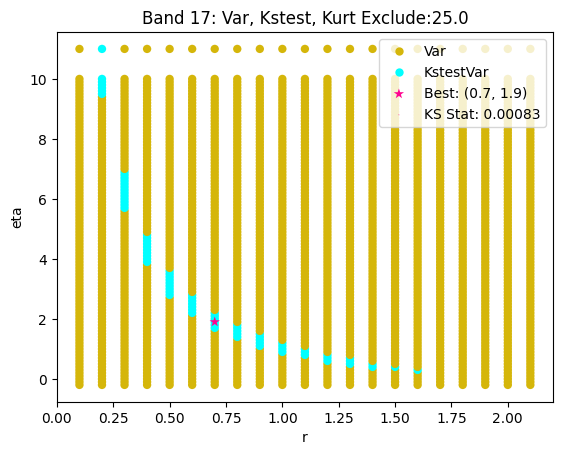

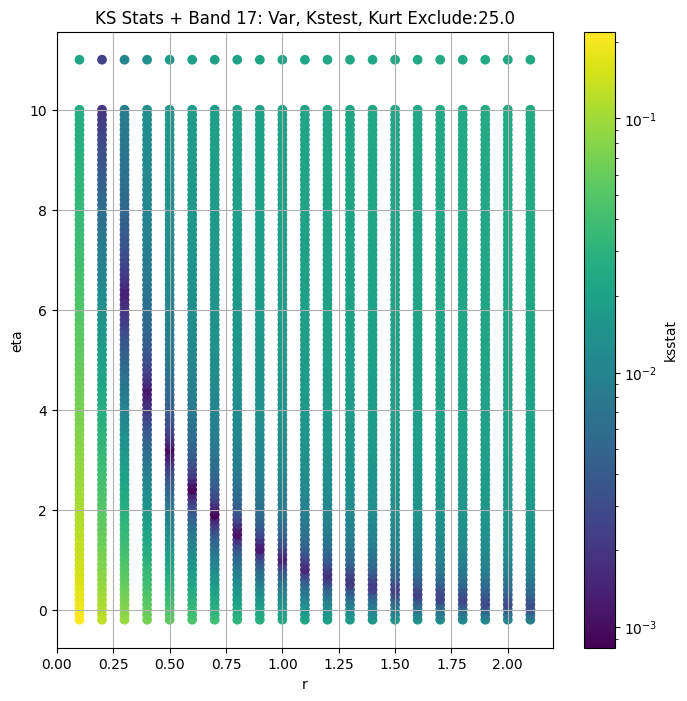

####
Band  20


100%|██████████| 12760/12760 [00:27<00:00, 462.21it/s]


Finding Minimum after computing 12760 CDFs
20 0 0.0009328528161731686 0.26062724


100%|██████████| 12760/12760 [00:27<00:00, 463.21it/s]


Finding Minimum after computing 12760 CDFs
20 25 0.0009300378833981826 0.2562057


100%|██████████| 12760/12760 [01:41<00:00, 125.68it/s]


Finding Minimum after computing 12760 CDFs
20 50 0.001063309572355453 0.2535443


100%|██████████| 12760/12760 [00:28<00:00, 452.48it/s]


Finding Minimum after computing 12760 CDFs
20 75 0.0013500585497340234 0.25126967
Number of samples: 100000, Without approximation : 381600.0


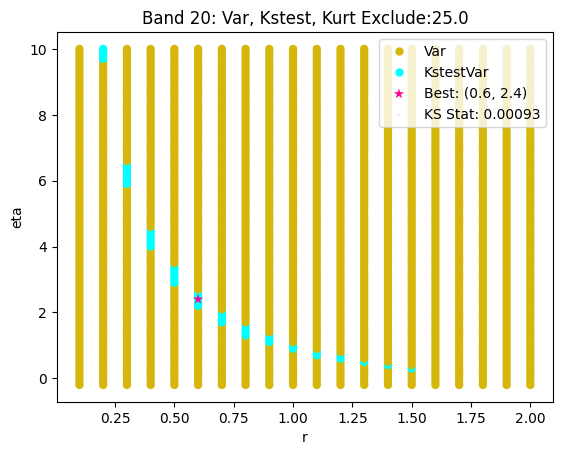

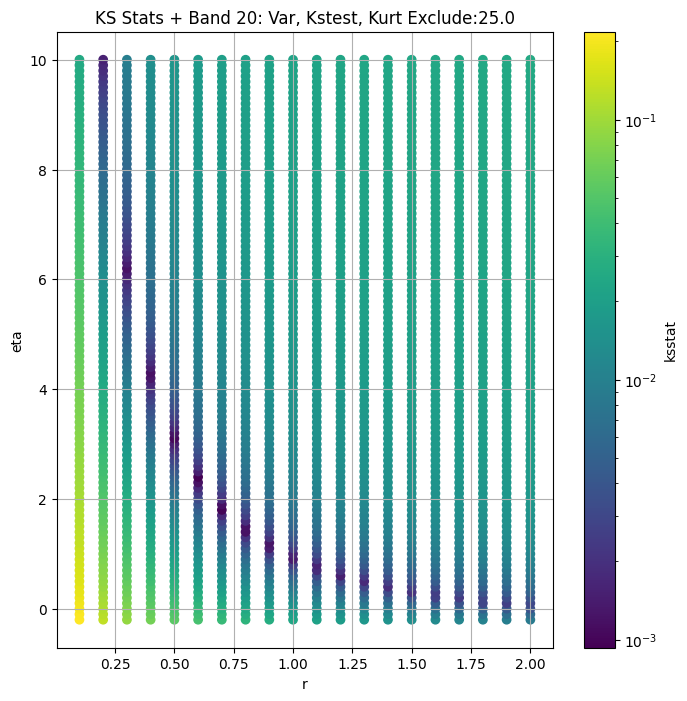

####
Band  23


100%|██████████| 12760/12760 [00:27<00:00, 461.37it/s]


Finding Minimum after computing 12760 CDFs
23 0 0.001493255361658119 0.12215869


100%|██████████| 12760/12760 [00:27<00:00, 462.72it/s]


Finding Minimum after computing 12760 CDFs
23 25 0.0015010277723339072 0.11991333


100%|██████████| 12760/12760 [00:27<00:00, 461.99it/s]


Finding Minimum after computing 12760 CDFs
23 50 0.001492600639119157 0.11857531


100%|██████████| 12760/12760 [00:27<00:00, 463.89it/s]


Finding Minimum after computing 12760 CDFs
23 75 0.0014868475569715378 0.117447


100%|██████████| 12760/12760 [00:27<00:00, 464.36it/s]


Finding Minimum after computing 12760 CDFs
23 100 0.0017833280135296503 0.11644758
Number of samples: 100000, Without approximation : 610560.0


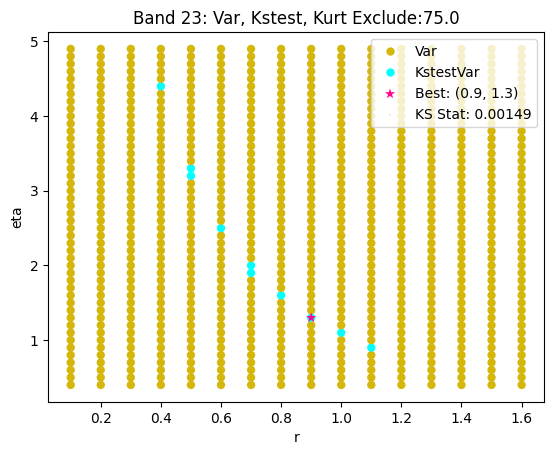

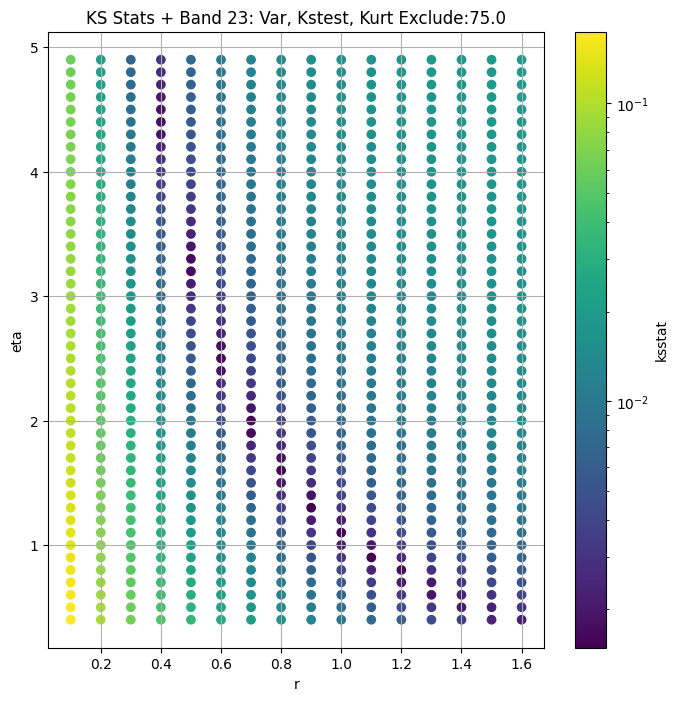

####
Band  26


100%|██████████| 12760/12760 [00:27<00:00, 462.43it/s]


Finding Minimum after computing 12760 CDFs
26 0 0.0022743943911064934 0.04917801


100%|██████████| 12760/12760 [00:33<00:00, 384.65it/s]


Finding Minimum after computing 12760 CDFs
26 25 0.0007504780114355181 0.04763038


100%|██████████| 12760/12760 [00:32<00:00, 390.50it/s]


Finding Minimum after computing 12760 CDFs
26 50 0.0008243232055006322 0.046922714


100%|██████████| 12760/12760 [00:34<00:00, 370.97it/s]


Finding Minimum after computing 12760 CDFs
26 75 0.0011751393927049714 0.046375502
Number of samples: 100000, Without approximation : 973080.0


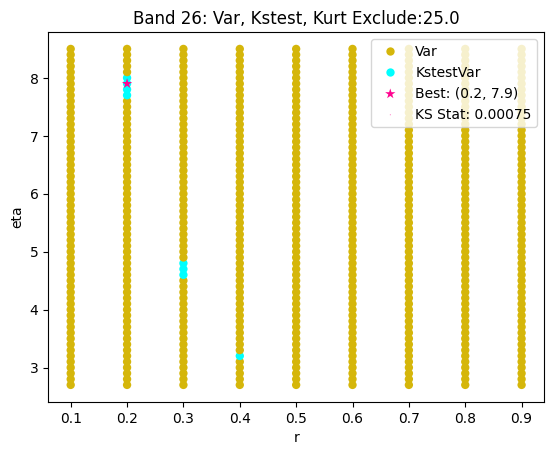

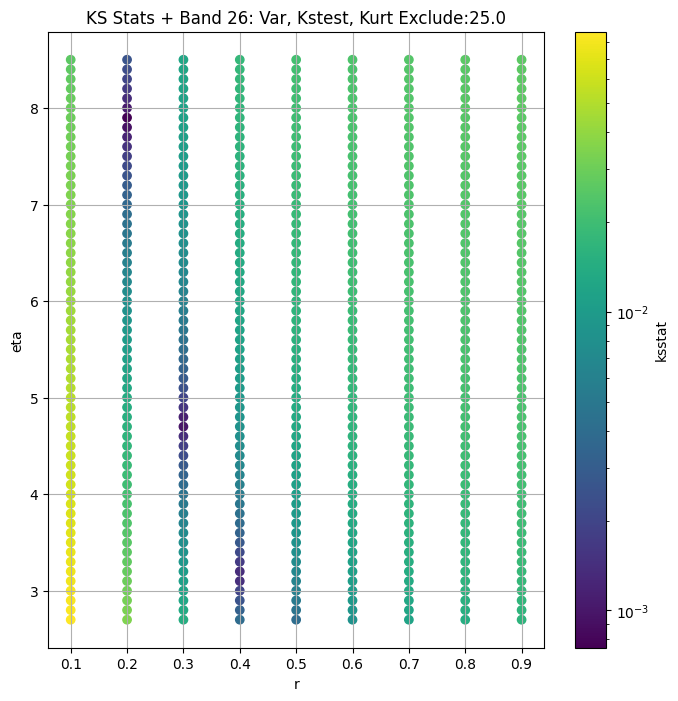

####
Band  29


100%|██████████| 12760/12760 [00:32<00:00, 389.78it/s]


Finding Minimum after computing 12760 CDFs
29 0 0.007042235706954572 0.01554814


100%|██████████| 12760/12760 [00:31<00:00, 403.70it/s]


Finding Minimum after computing 12760 CDFs
29 25 0.004320276250942556 0.014465072


100%|██████████| 12760/12760 [00:31<00:00, 403.95it/s]


Finding Minimum after computing 12760 CDFs
29 50 0.0028943203697168185 0.014051098


100%|██████████| 12760/12760 [00:31<00:00, 399.26it/s]


Finding Minimum after computing 12760 CDFs
29 75 0.0021125452919478205 0.013758862


100%|██████████| 12760/12760 [00:31<00:00, 399.63it/s]


Finding Minimum after computing 12760 CDFs
29 100 0.0016561569935995557 0.0135306865


100%|██████████| 12760/12760 [00:31<00:00, 402.26it/s]


Finding Minimum after computing 12760 CDFs
29 150 0.0021178719950670777 0.013175184


100%|██████████| 12760/12760 [00:31<00:00, 402.43it/s]


Finding Minimum after computing 12760 CDFs
29 200 0.0026266577546125713 0.012895831
Number of samples: 100000, Without approximation : 1376940.0


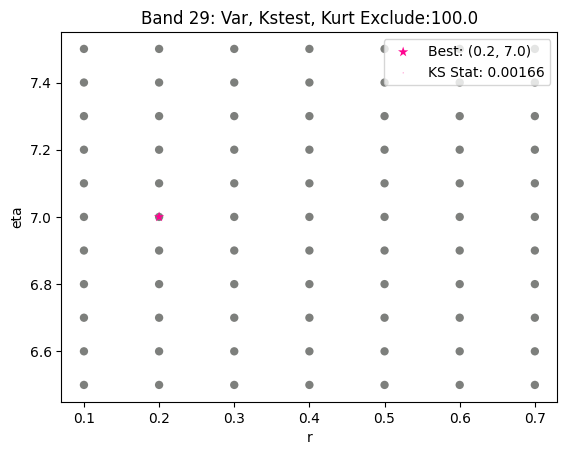

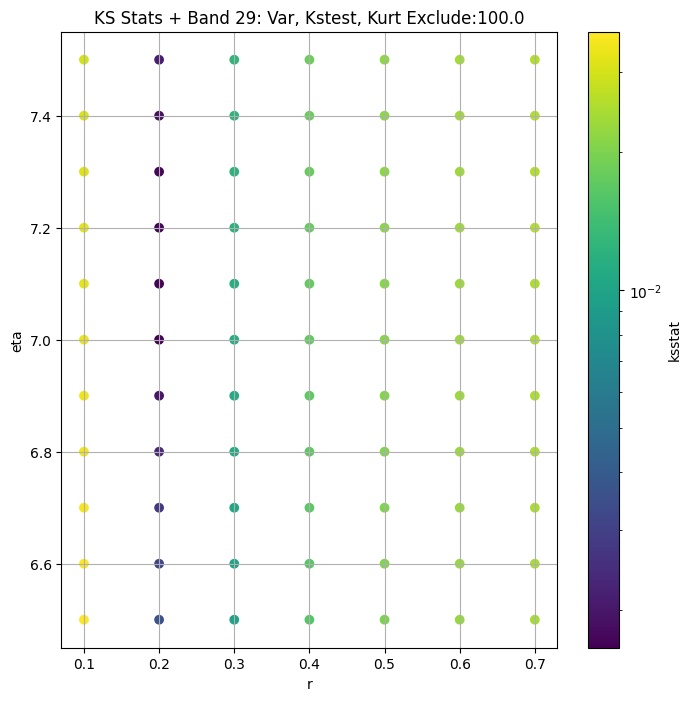

####
Band  32


100%|██████████| 12760/12760 [00:32<00:00, 391.16it/s]


Finding Minimum after computing 12760 CDFs
32 0 0.0014244750435071785 0.0013369159


100%|██████████| 12760/12760 [00:31<00:00, 411.50it/s]


Finding Minimum after computing 12760 CDFs
32 25 0.001422213805131689 0.0013176324


100%|██████████| 12760/12760 [00:30<00:00, 412.24it/s]


Finding Minimum after computing 12760 CDFs
32 50 0.001396935497456557 0.001304606


100%|██████████| 12760/12760 [00:32<00:00, 395.77it/s]


Finding Minimum after computing 12760 CDFs
32 75 0.0016475954676503646 0.001293449


100%|██████████| 12760/12760 [00:31<00:00, 406.91it/s]


Finding Minimum after computing 12760 CDFs
32 100 0.001984819018362338 0.0012835086
Number of samples: 100000, Without approximation : 419760.0


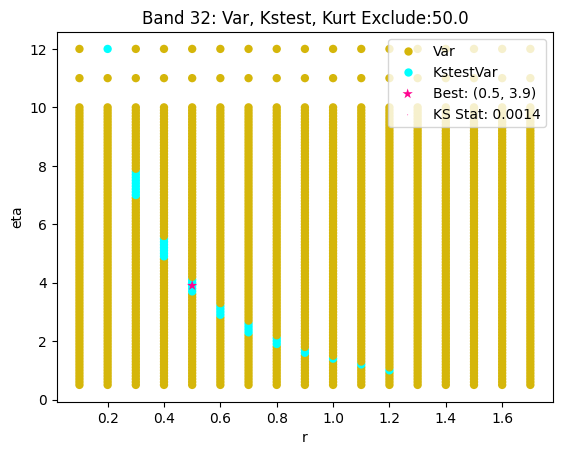

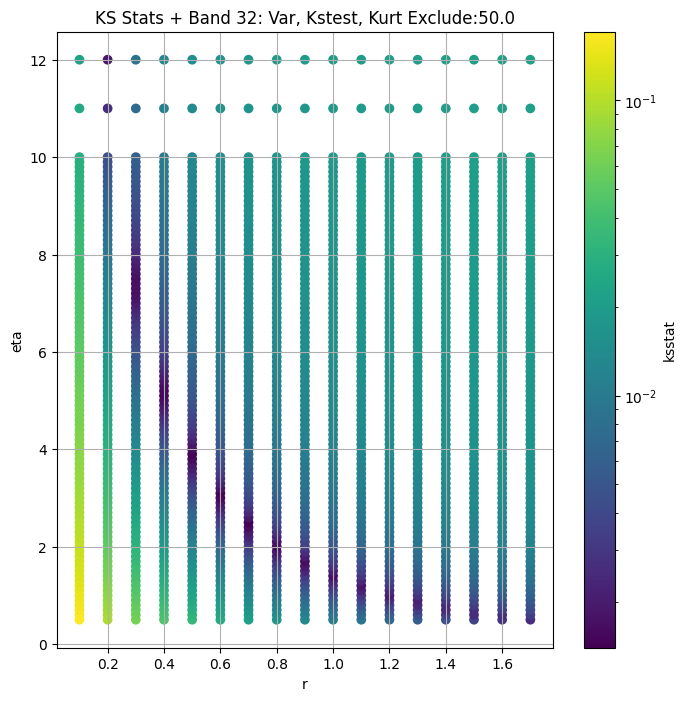

obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                       
2     10.134422   9.643435  10.646572   1.621352    1.183683    2.159779   
5      5.424390   5.164831   5.694692   1.556881    1.034867    2.247035   
8      2.974848   2.833664   3.120628   1.541575    1.065818    2.175573   
11     1.695055   1.610400   1.784300   1.922300    1.152667    3.322009   
14     0.926228   0.881725   0.973125   1.705795    1.083743    3.005845   
17     0.518186   0.492855   0.544779   1.771588    1.108579    3.490519   
20     0.260627   0.247789   0.274535   1.956200    1.143715    5.900508   
23     0.122159   0.116055   0.128693   2.041856    1.252694    3.881752   
26     0.049178   0.046151   0.053056   5.035482    1.824682   19.982931   
29     0.015548   0.014031   0.017973  20.922686    4.499840   88.633370   
32     0.001337   0.001274   0.001402   1.474466    0.992683    2.485555   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2           31800.0             0.003466        0.2          9.1   
5           41340.0             0.002571        1.0          1.4   
8           66780.0             0.003198        0.3          7.6   
11         104940.0             0.001670        0.5          3.8   
14         162180.0             0.002577        1.1          1.2   
17         257580.0             0.000828        0.7          1.9   
20         381600.0             0.000930        0.6          2.4   
23         610560.0             0.001487        0.9          1.3   
26         973080.0             0.000750        0.2          7.9   
29        1376940.0             0.001656        0.2          7.0   
32         419760.0             0.001397        0.5          3.9   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      2.016990e-08                     0.0           10.134422   
5      1.815168e+00                    25.0            5.263988   
8      2.917458e-05                    50.0            2.875796   
11     1.337855e-02                    50.0            1.645027   
14     4.050024e-01                    50.0            0.901737   
17     5.019805e-02                    25.0            0.509296   
20     1.043959e-02                    25.0            0.256206   
23     3.266508e-02                    75.0            0.117447   
26     1.689696e-10                    25.0            0.047630   
29     7.773512e-11                   100.0            0.013531   
32     1.023702e-05                    50.0            0.001305   

      kstest_stat_cutoff_0.05  
band                           
2                    0.007611  
5                    0.006675  
8                    0.005253  
11                   0.004191  
14                   0.003371  
17                   0.002675  
20                   0.002198  
23                   0.001738  
26                   0.001377  
29                   0.001157  
32                   0.002096

In [14]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1
        no_improvement_counter = 0

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]

            if no_improvement_counter > 1:
                break

            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
            else:
                no_improvement_counter += 1
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

In [15]:
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                             
2     10.134422      10.134422        9.782848        9.546412   
5      5.424390       5.424390        5.263988        5.168985   
8      2.974848       2.974848        2.915290        2.875796   
11     1.695055       1.695055        1.663257        1.645027   
14     0.926228       0.926228        0.911027        0.901737   
17     0.518186       0.518186        0.509296        0.503911   
20     0.260627       0.260627        0.256206        0.253544   
23     0.122159       0.122159        0.119913        0.118575   
26     0.049178       0.049178        0.047630        0.046923   
29     0.015548       0.015548        0.014465        0.014051   
32     0.001337       0.001337        0.001318        0.001305   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2           9.353152         9.182628         8.889160         8.640179   
5           5.086771         5.014502         4.888740         4.776872   
8           2.842202         2.812102         2.758150         2.710952   
11          1.629946         1.616589         1.593062         1.572441   
14          0.893657         0.886373         0.873591         0.862387   
17          0.499483         0.495506         0.488453         0.482207   
20          0.251270         0.249237         0.245621         0.242386   
23          0.117447         0.116448         0.114696         0.113161   
26          0.046376         0.045902         0.045096         0.044404   
29          0.013759         0.013531         0.013175         0.012896   
32          0.001293         0.001284         0.001266         0.001250   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  \
band                                                                       
2            8.418350         8.217493         8.032310         7.546413   
5            4.675648         4.582586         4.496524         4.266775   
8            2.668601         2.629780         2.593668         2.497113   
11           1.553386         1.535631         1.518962         1.474134   
14           0.852188         0.842727         0.833824         0.809826   
17           0.476513         0.471247         0.466325         0.453006   
20           0.239438         0.236714         0.234168         0.227321   
23           0.111766         0.110477         0.109277         0.106054   
26           0.043791         0.043232         0.042716         0.041357   
29           0.012662         0.012459         0.012277         0.011813   
32           0.001236         0.001222         0.001210         0.001176   

      kstest_stat_0  kstest_stat_25  kstest_stat_50  kstest_stat_75  \
band                                                                  
2          0.003466        0.003487        0.003485             NaN   
5          0.002604        0.002571        0.003152        0.003816   
8          0.003311        0.003261        0.003198        0.003198   
11         0.001950        0.001680        0.001670        0.001693   
14         0.002605        0.002638        0.002577        0.002627   
17         0.000834        0.000828        0.001114        0.001509   
20         0.000933        0.000930        0.001063        0.001350   
23         0.001493        0.001501        0.001493        0.001487   
26         0.002274        0.000750        0.000824        0.001175   
29         0.007042        0.004320        0.002894        0.002113   
32         0.001424        0.001422        0.001397        0.001648   

      kstest_stat_100  kstest_stat_150  kstest_stat_200  
band                                                     
2                 NaN              NaN              NaN  
5                 NaN              NaN              NaN  
8            0.003316       

In [16]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

In [17]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

## Comparing Empirical and Computed CDF/PDF

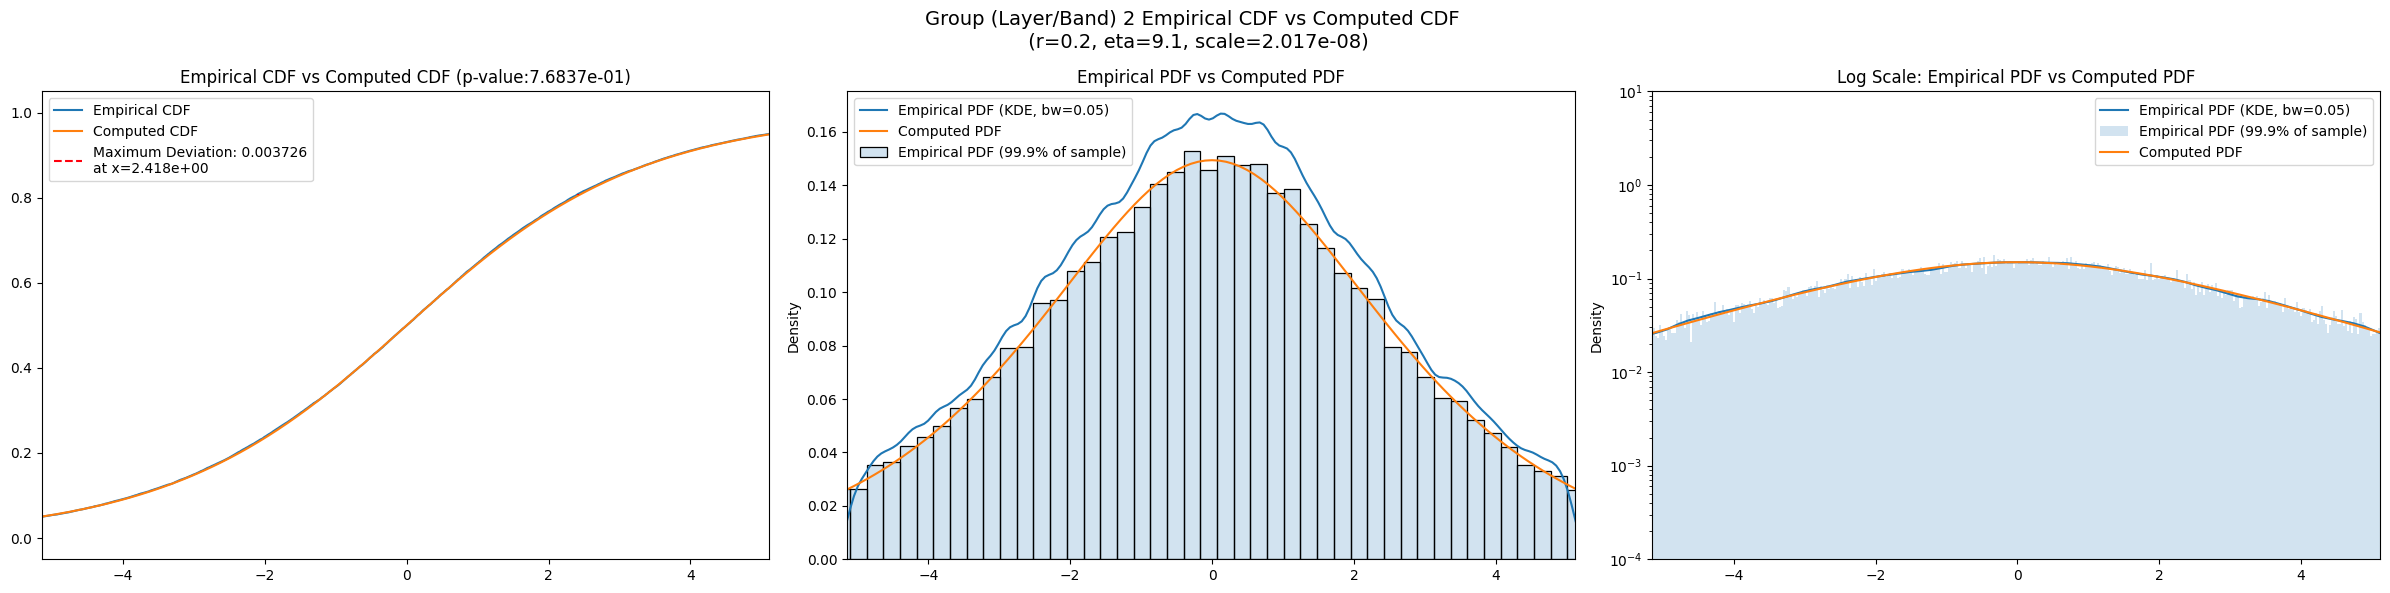

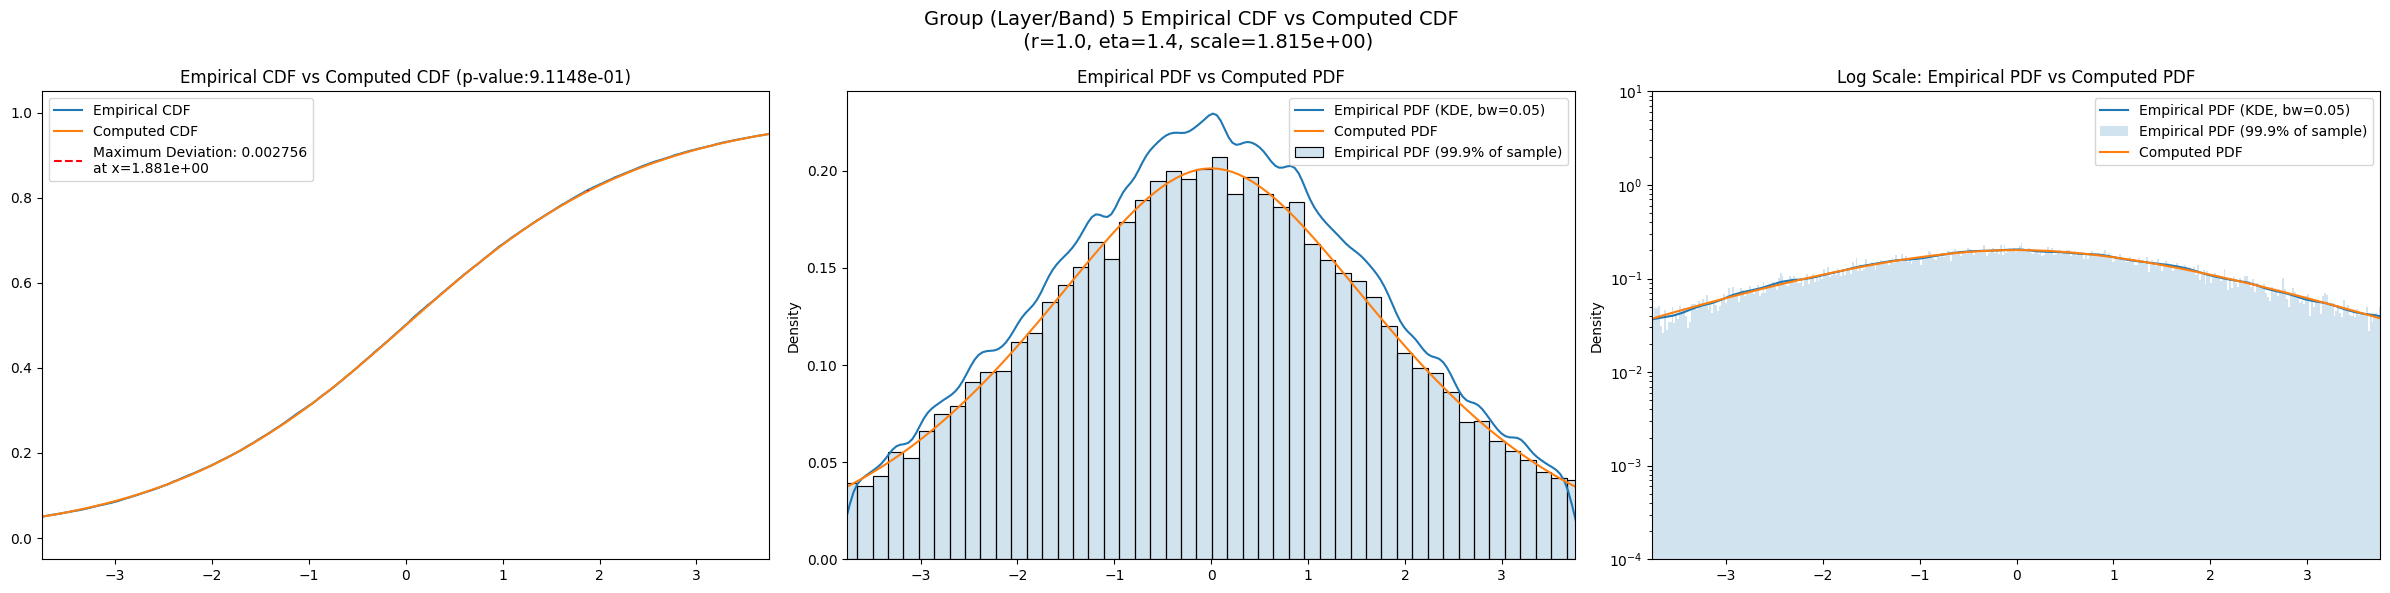

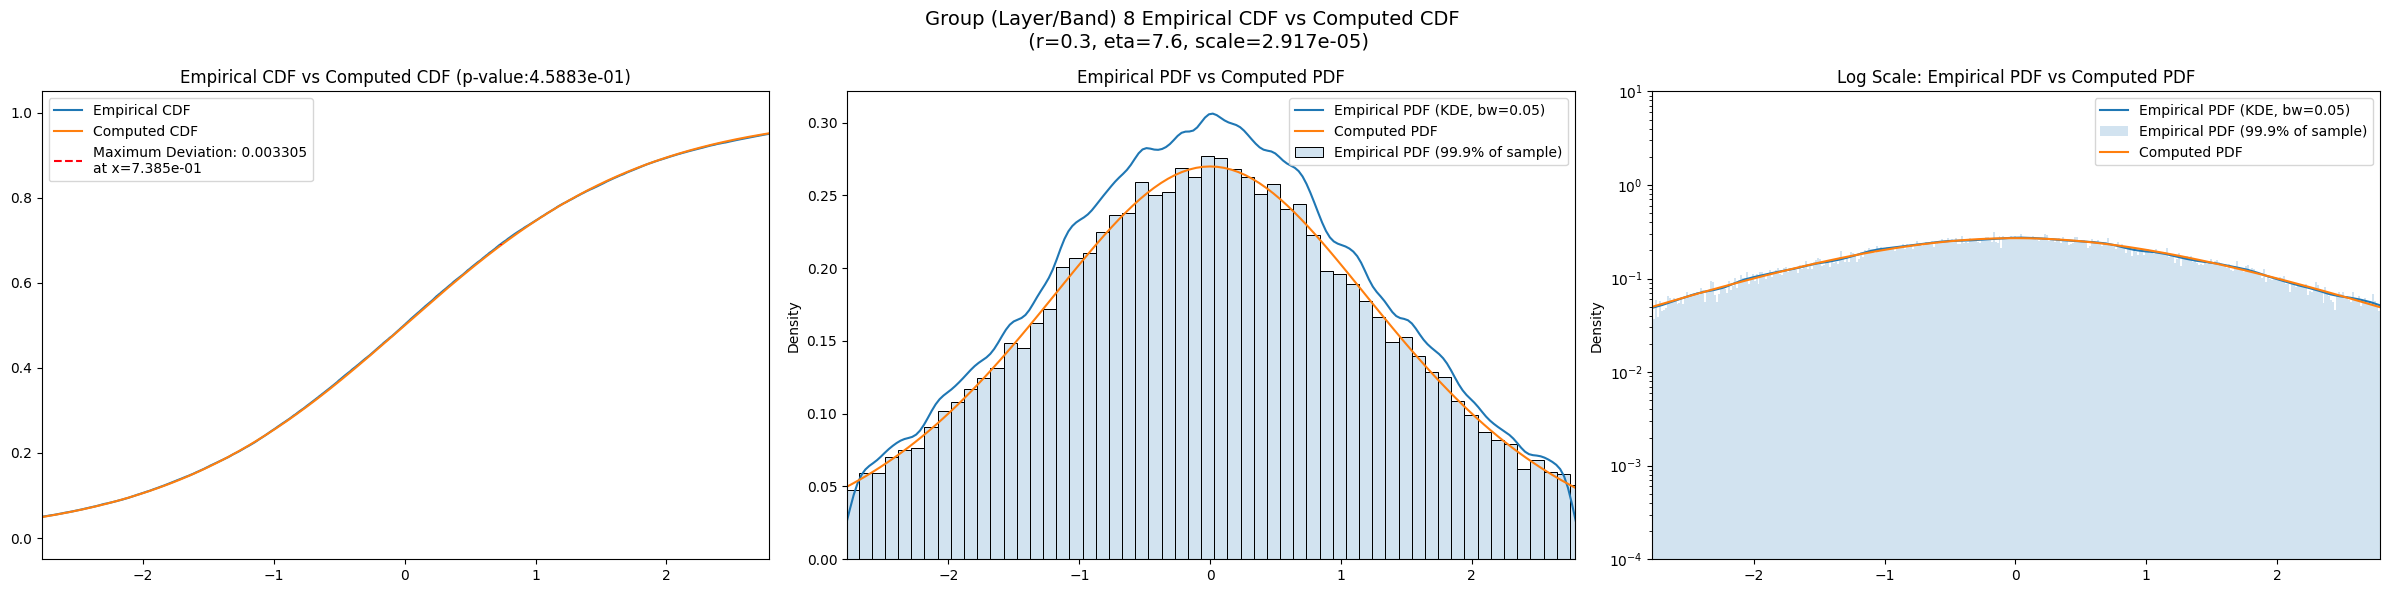

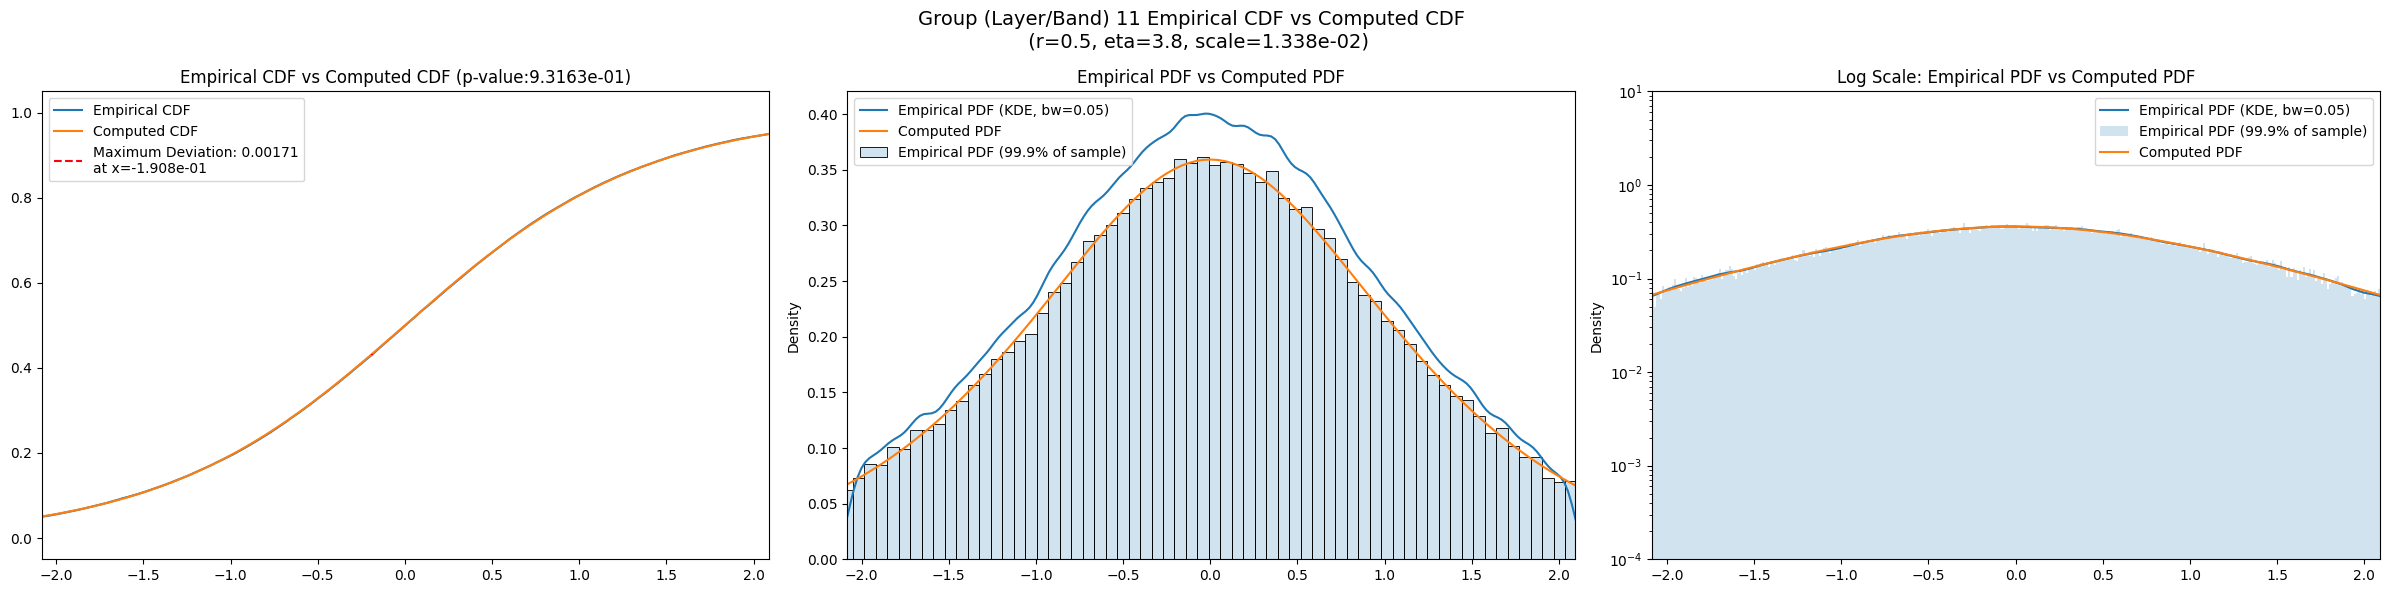

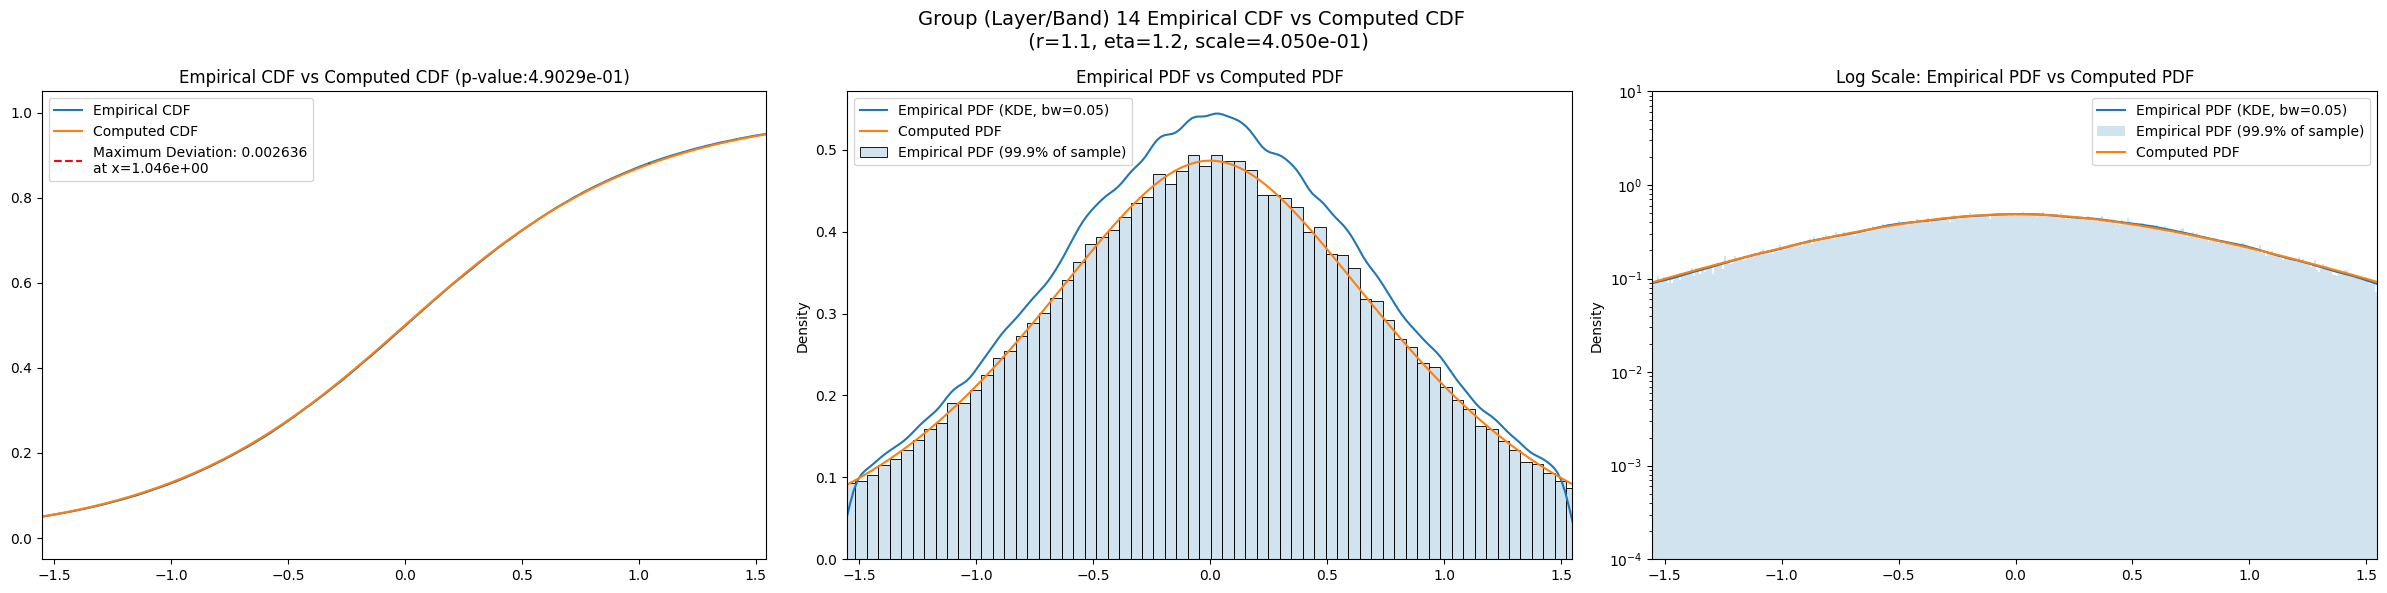

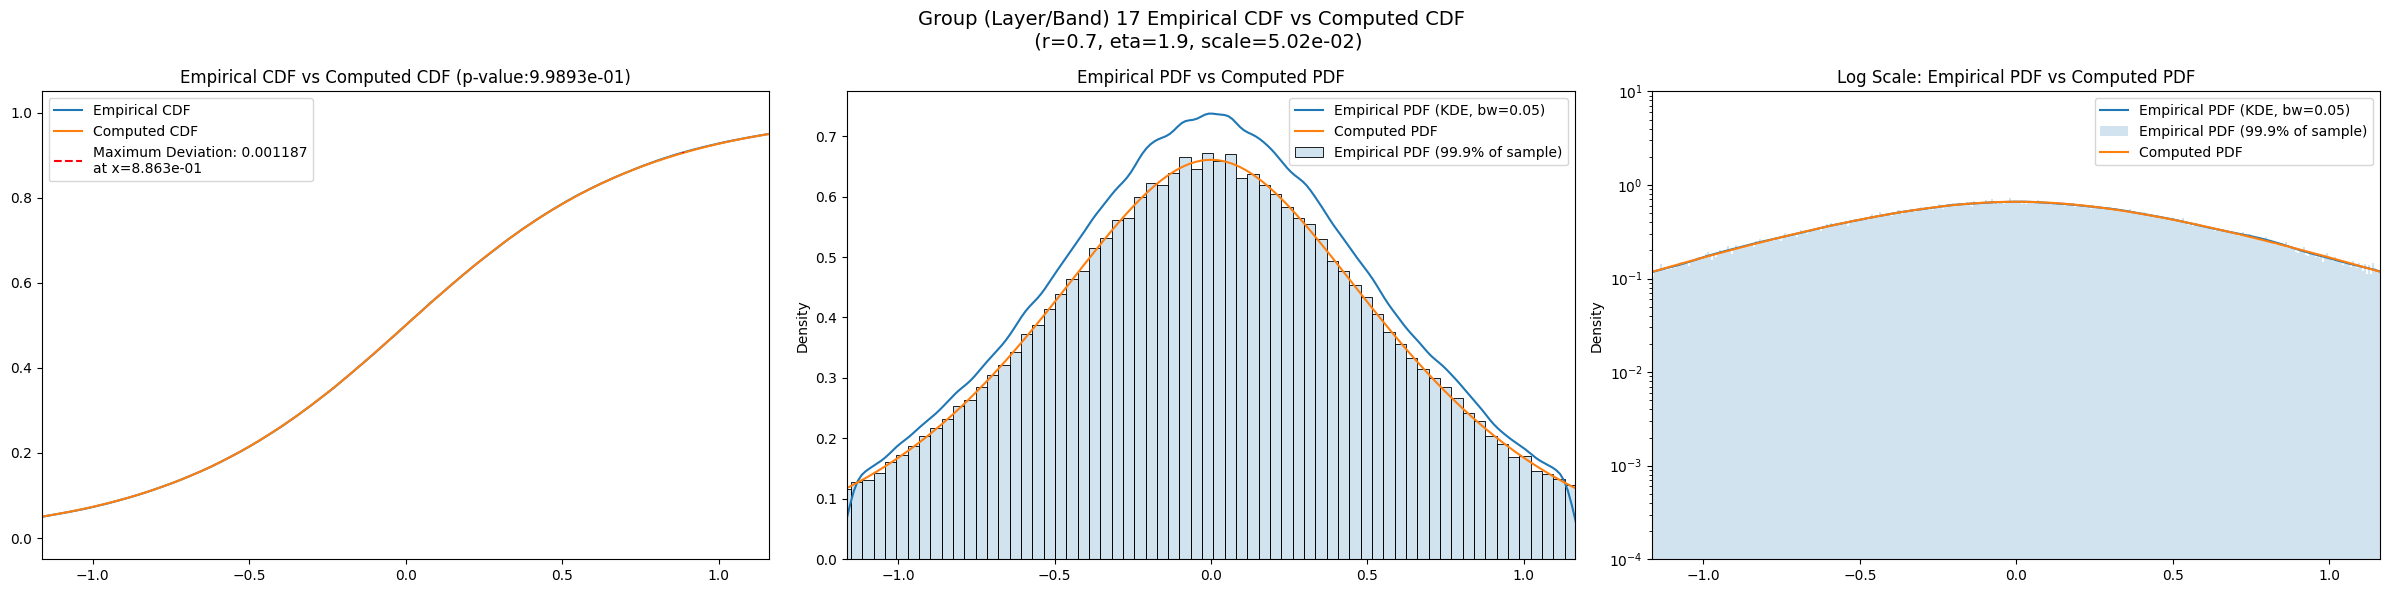

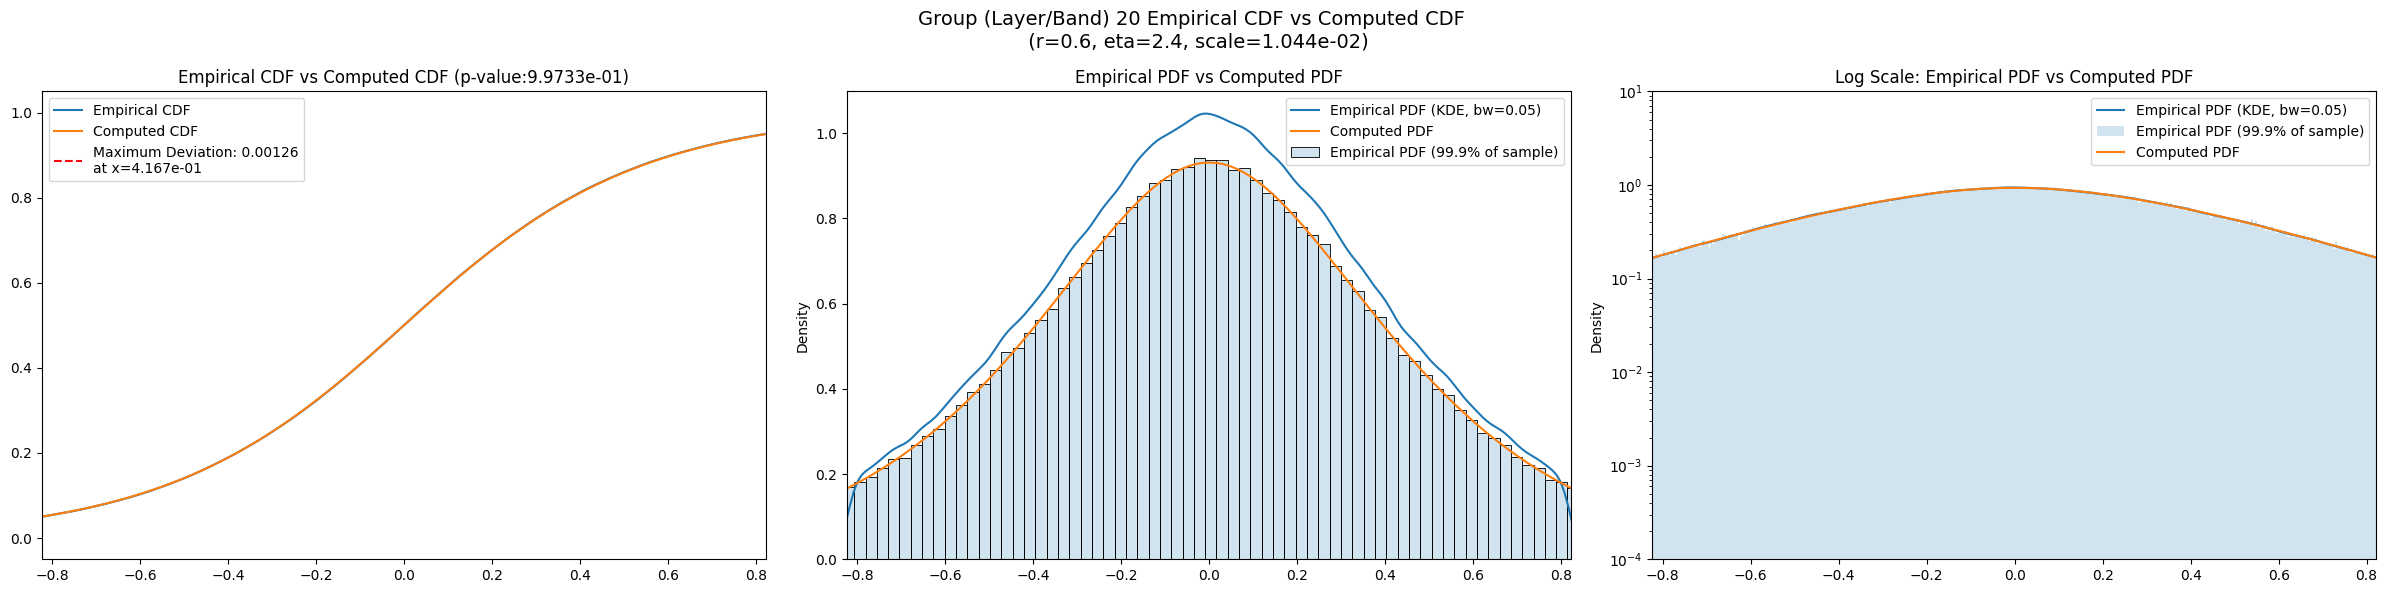

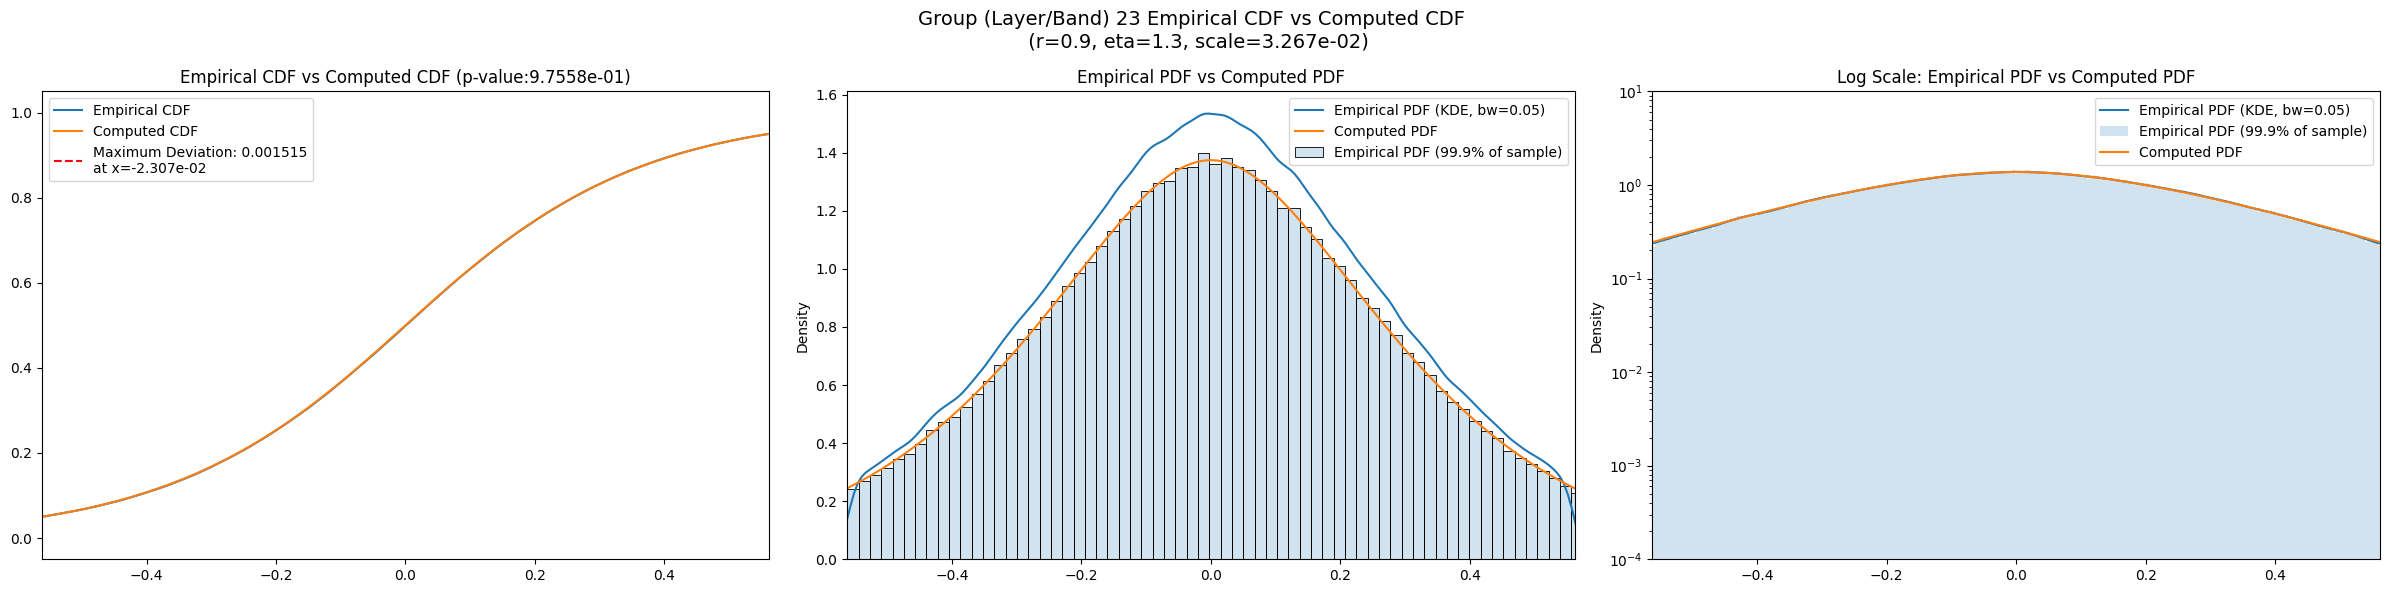

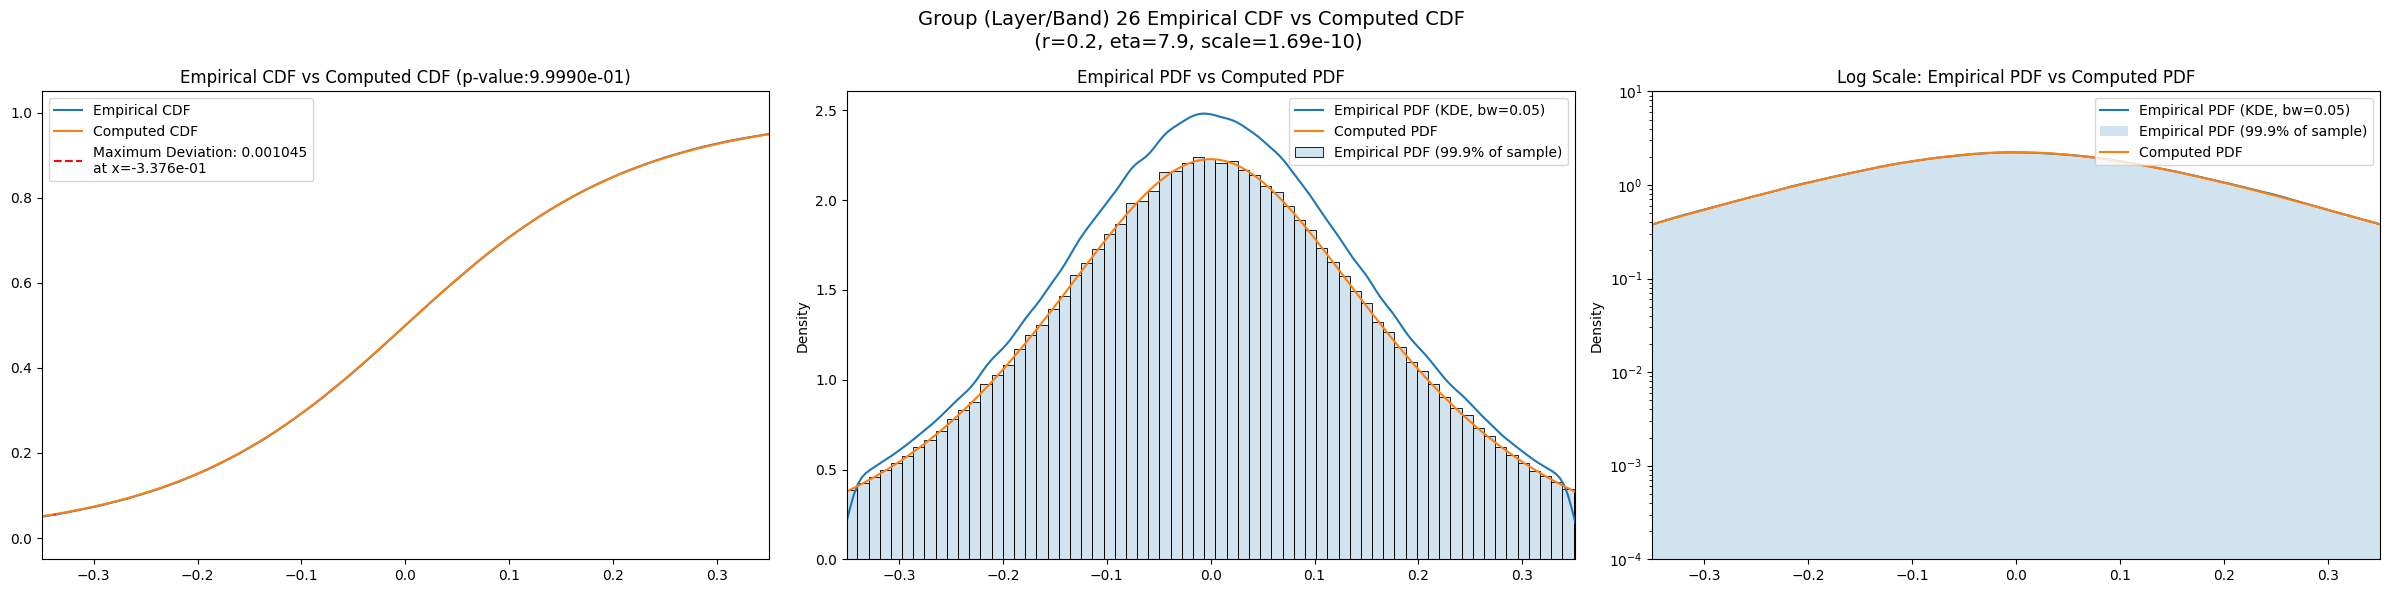

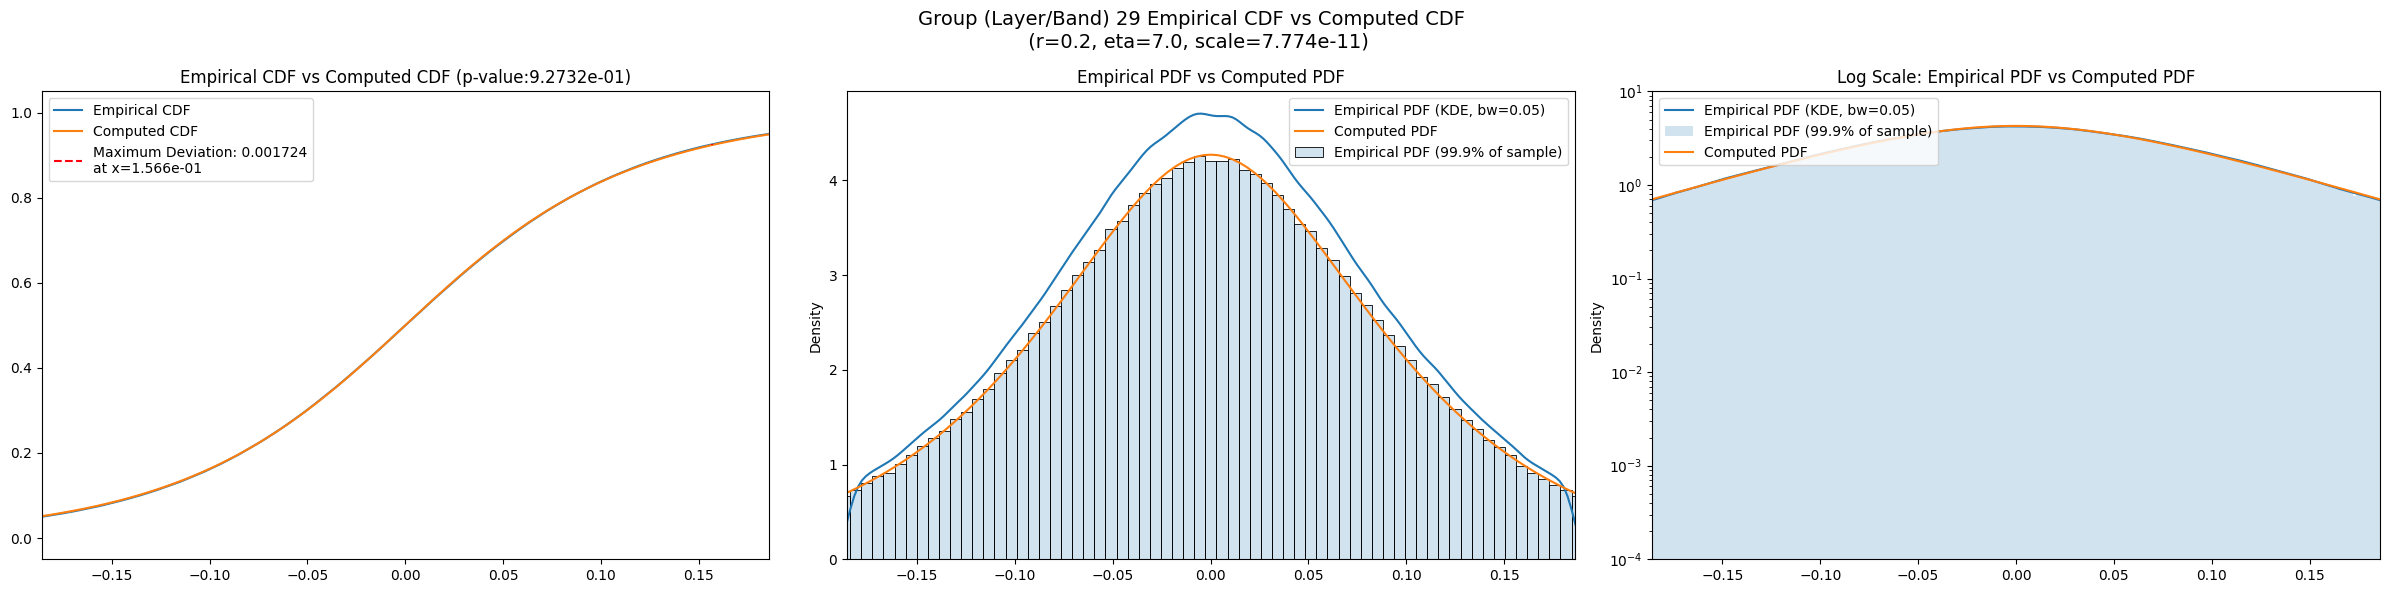

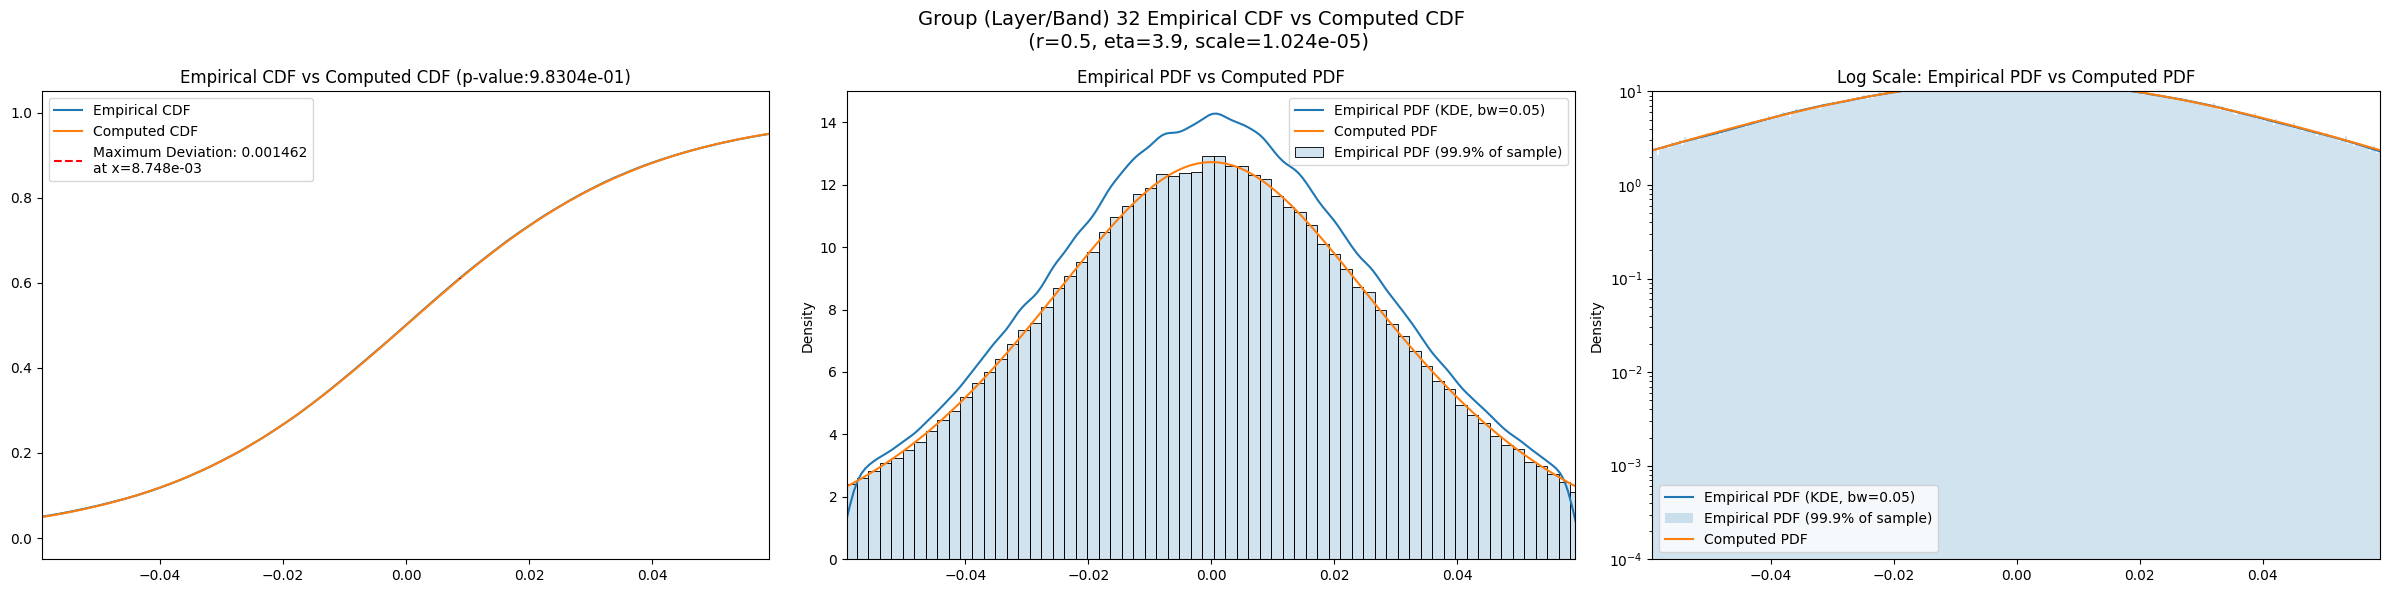

In [19]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [20]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [5]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

NameError: name 'Path' is not defined

## Results

In [24]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

FileNotFoundError: [Errno 2] No such file or directory

In [3]:
master_df

NameError: name 'master_df' is not defined

In [28]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))

In [2]:
master_df.columns

NameError: name 'master_df' is not defined

In [1]:
master_df['kstest_stat_cutoff_0.05']

NameError: name 'master_df' is not defined

In [ ]:
columns_interest = ['kstest_stat_gaussian', 'kstest_stat_laplace', 'kstest_stat_t', 'kstest_stat_best']
master_df[columns_interest]

kstest_pval_gaussian  kstest_pval_laplace  kstest_pval_t  \
band                                                             
2             9.368110e-06         4.601080e-09   1.079090e-12   
5             2.370910e-05         2.254810e-13   2.570410e-17   
8             4.320490e-09         1.164030e-24   5.918010e-28   
11            4.510420e-12         3.241720e-35   3.482490e-42   
14            1.732980e-18         4.571520e-56   1.991250e-66   
17            5.899590e-33         7.367720e-68   2.707250e-92   
20            7.332310e-50         1.988710e-98  4.194530e-135   
23            8.052380e-87        7.794140e-161  1.621600e-211   
26           2.236750e-156        2.806680e-230  2.829970e-295   
29           7.801880e-251        2.055400e-303   0.000000e+00   
32            4.382290e-48        5.574940e-131  2.400680e-162   

      kstest_pval_gengamma  
band                        
2                 0.838132  
5                 0.946786  
8                 0.500879  
11                0.931198  
14                0.231350  
17                0.994422  
20                0.895803  
23                0.134298  
26                0.643216  
29                0.001047  
32                0.385433

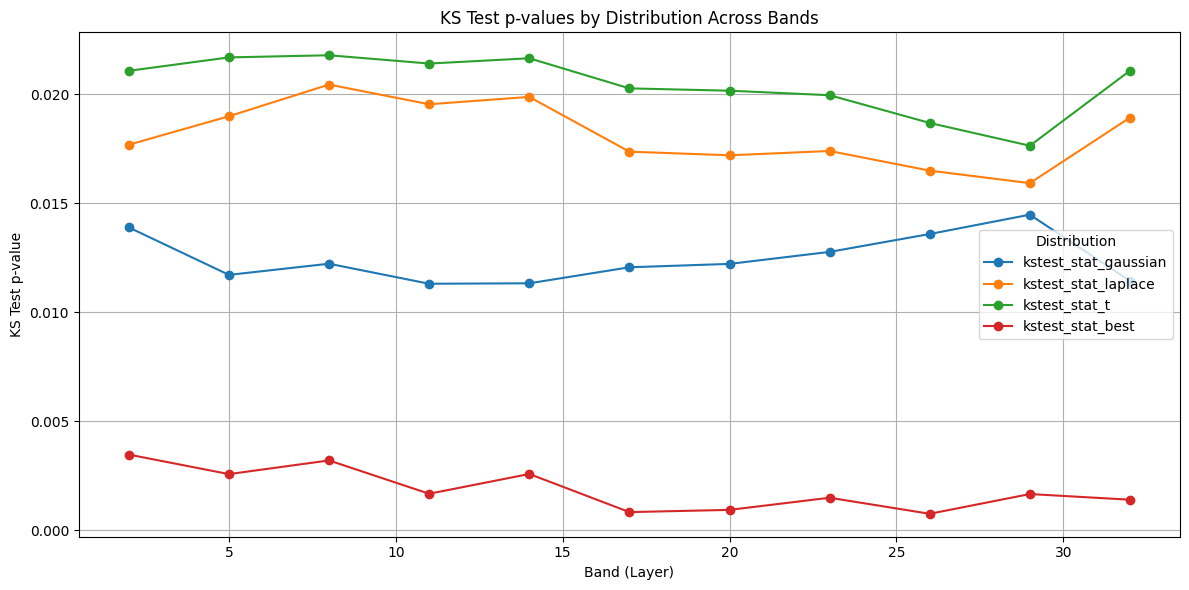

In [34]:
import matplotlib.pyplot as plt

# Define the columns of interest
columns_interest = ['kstest_stat_gaussian', 'kstest_stat_laplace', 'kstest_stat_t', 'kstest_stat_best']

# Plotting
plt.figure(figsize=(12, 6))

for col in columns_interest:
    plt.plot(master_df.index, master_df[col], marker='o', label=col.replace('kstest_pval_', ''))

plt.xlabel('Band (Layer)')
plt.ylabel('KS Test p-value')
plt.title('KS Test p-values by Distribution Across Bands')
plt.legend(title='Distribution')
plt.grid(True)
plt.tight_layout()
plt.show()
